# Data visualisation

In [ ]:
# !pip install kneed

Defaulting to user installation because normal site-packages is not writeable


In [26]:
# IMPORTS
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## R to Python

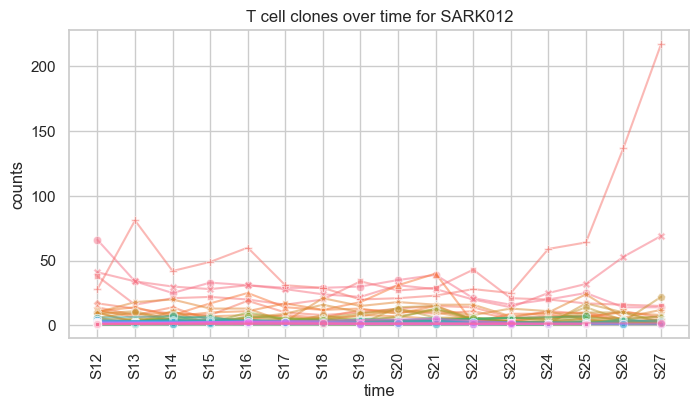

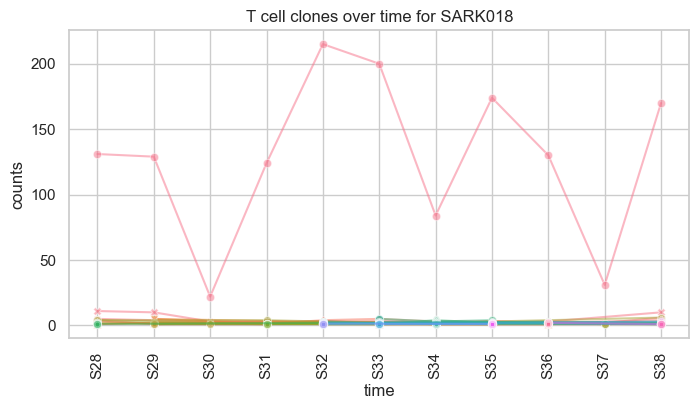

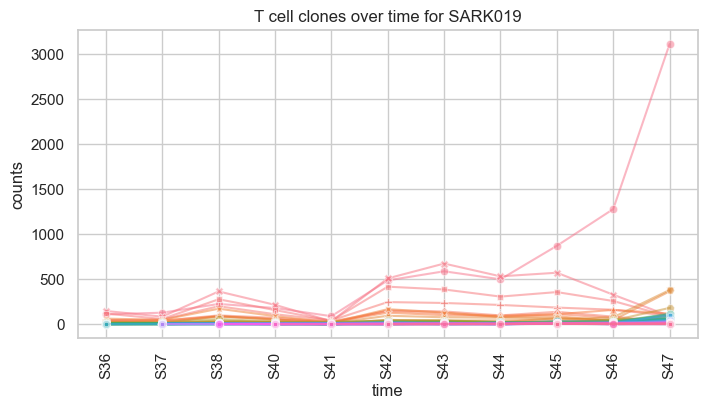

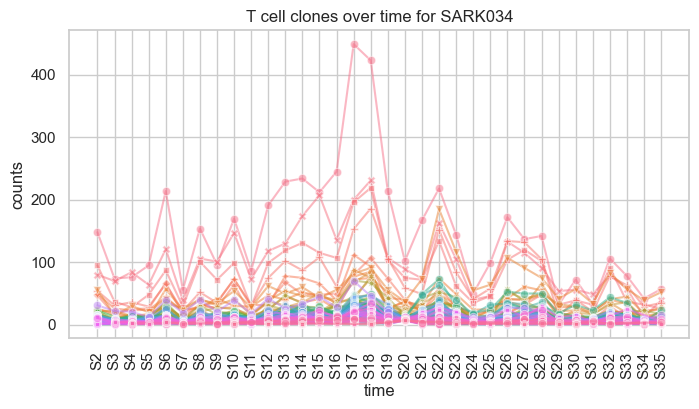

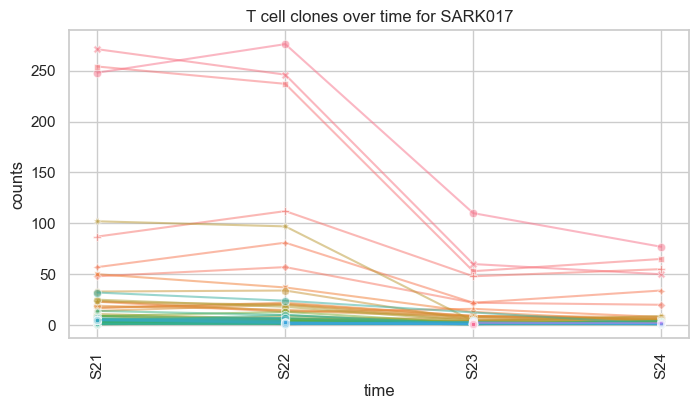

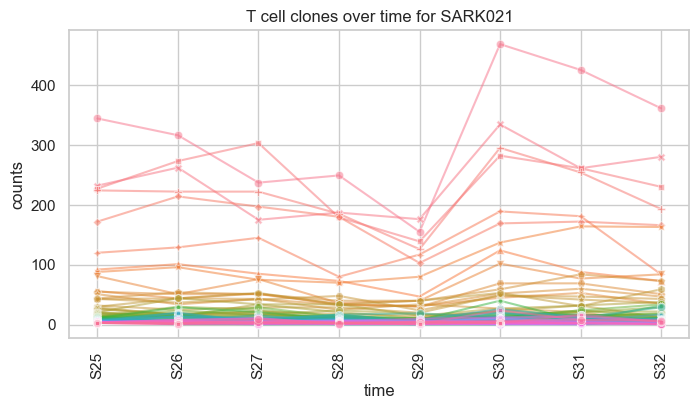

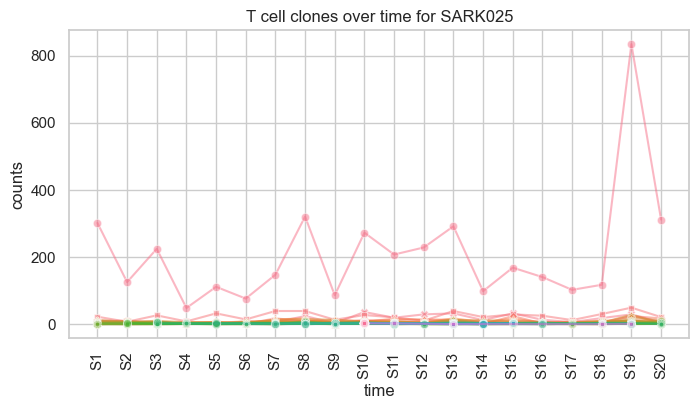

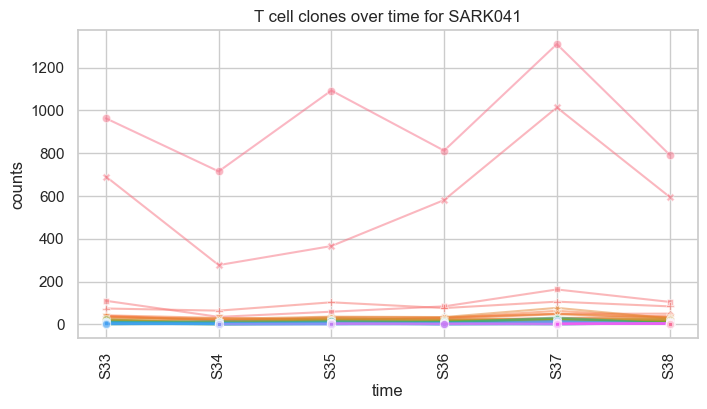

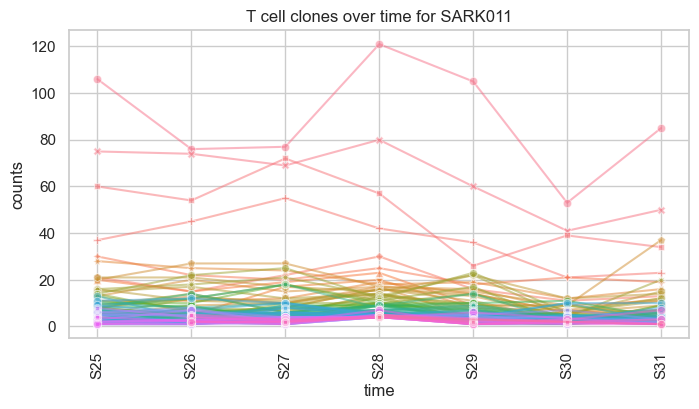

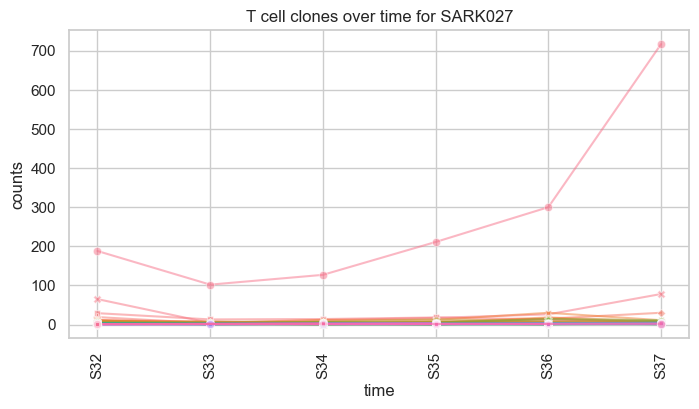

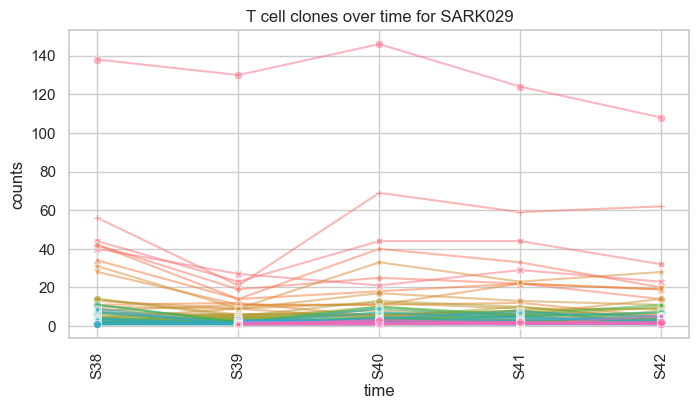

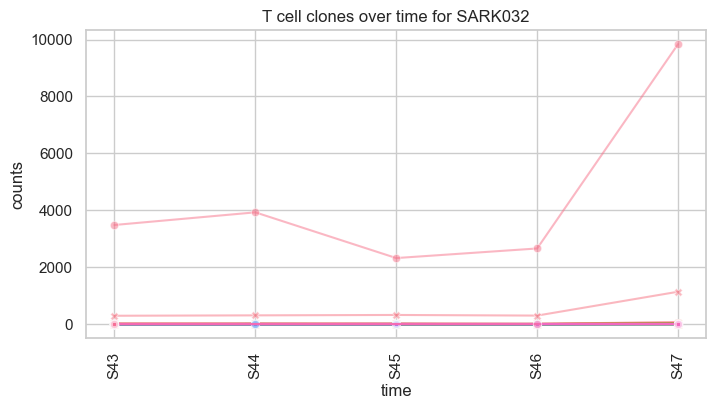

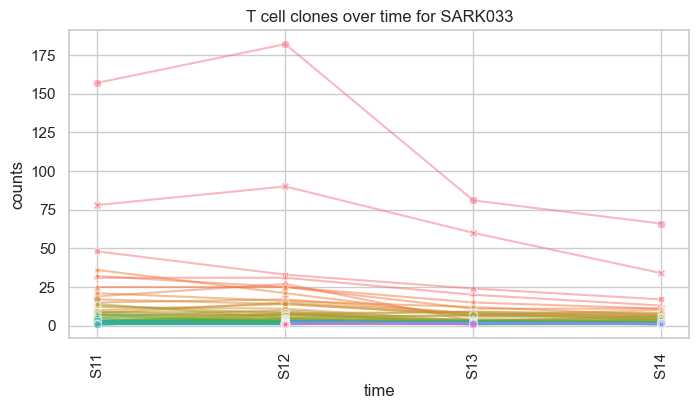

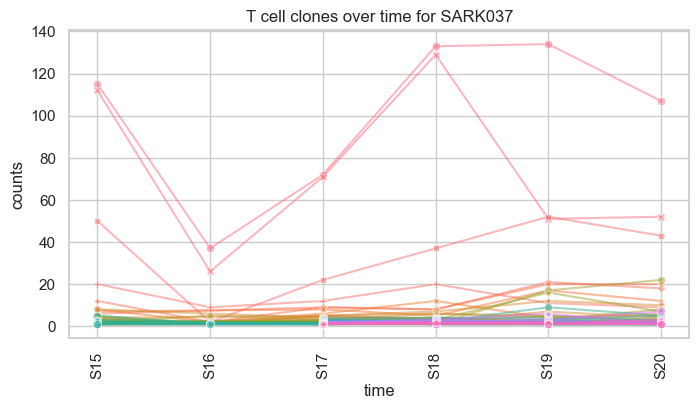

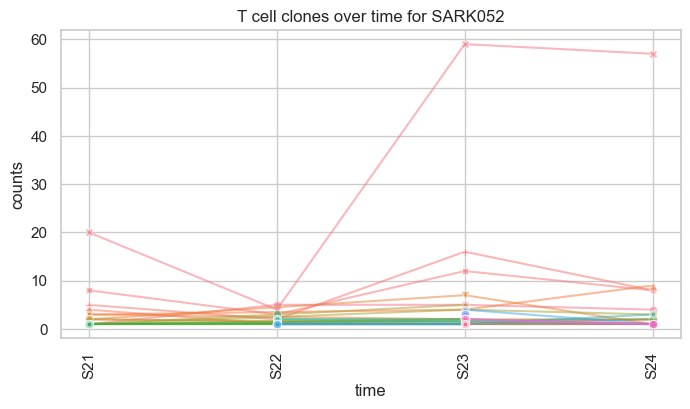

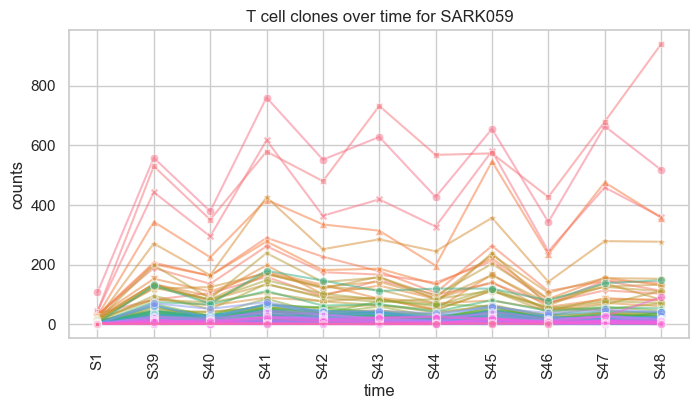

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set Seaborn style
sns.set(style="whitegrid")

# IMPORT DATA
pat_list = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK017', 'SARK021', 'SARK025', 
            'SARK041', 'SARK011', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK052', 'SARK059']

file_path = 'TCR_sequencing_all_samples_adjusted_20240508.xlsx'

# Load the Excel file for each patient
for i, pat in enumerate(pat_list):
    sheet_index = (i + 1) * 2 - 2
    tcr_df = pd.read_excel(file_path, sheet_name=sheet_index, engine='openpyxl')

    # Remove rows where 'CDR3.amino.acid.sequence' is NaN
    tcr_df = tcr_df.dropna(subset=['CDR3.amino.acid.sequence'])

    # Select columns containing '_S'
    tcr_counts = tcr_df.filter(regex='_S').copy()

    # Rename columns by extracting the part after '_'
    tcr_counts.columns = [col.split('_')[1] for col in tcr_counts.columns]

    # Limit to the first 100 sequences
    tcr_counts = tcr_counts.head(100)

    # Drop time steps where all values are NaN (fully missing)
    tcr_counts = tcr_counts.dropna(axis=1, how="all")

    # Add an ID column
    tcr_counts['id'] = ['TCR' + str(j + 1) for j in range(len(tcr_counts))]

    # Melt the dataframe for plotting
    tcr_counts_m = tcr_counts.melt(id_vars='id', var_name='time', value_name='counts').copy()

    # Remove time points where all counts are zero
    tcr_counts_m = tcr_counts_m[tcr_counts_m['counts'] > 0]

    # Ensure the time axis contains only valid values for this patient
    valid_time_steps = sorted(tcr_counts_m['time'].unique(), key=lambda x: int(x[1:]))  # Sort numerically
    tcr_counts_m['time'] = pd.Categorical(tcr_counts_m['time'], categories=valid_time_steps, ordered=True)

    # Plot: Line Plot without empty time steps
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=tcr_counts_m, x='time', y='counts', hue='id', style='id', markers=True, dashes=False, alpha=0.5)
    plt.xticks(rotation=90)
    plt.title(f'T cell clones over time for {pat}')
    plt.legend().remove()  # Prevent legend clutter
    plt.show()


## Cacota

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# IMPORT DATA
pat_list = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK017', 'SARK021', 'SARK025', 
            'SARK041', 'SARK011', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK052', 'SARK059']

file_path = 'TCR_sequencing_all_samples_adjusted_20240508.xlsx'

# Load the Excel file
for i, pat in enumerate(pat_list):
    sheet_index = (i+1)*2-2
    tcr_df = pd.read_excel(file_path, sheet_name=sheet_index, engine='openpyxl')

    # Remove rows where 'CDR3.amino.acid.sequence' is NaN
    tcr_df = tcr_df.dropna(subset=['CDR3.amino.acid.sequence'])

    # Select columns containing '_S'
    tcr_counts = tcr_df.filter(regex='_S').copy()

    # Rename columns by extracting the part after '_'
    tcr_counts.columns = [col.split('_')[1] for col in tcr_counts.columns]

    # Add an ID column
    tcr_counts['id'] = ['TCR' + str(i + 1) for i in range(len(tcr_counts))]

    # Melt the dataframe for plotting
    tcr_counts_m = tcr_counts.melt(id_vars='id', var_name='time', value_name='counts').copy()

    # Set factor levels for 'variable' AND order the time steps
    tcr_counts_m['time'] = pd.Categorical(tcr_counts_m['time'], categories=[f'S{i}' for i in range(1, 51)], ordered=True)

    ## ✅ **Optimized & Faster Visualization**
    
    # 🚀 **1. Aggregated Line Plot (Avoids 10000+ lines)**
    plt.figure(figsize=(8, 4))
    
    # If sequences > 5000, use median + IQR instead of plotting all
    if len(tcr_counts_m['id'].unique()) > 5000:
        agg_df = tcr_counts_m.groupby('time')['counts'].agg(['median', lambda x: x.quantile(0.25), lambda x: x.quantile(0.75)])
        agg_df.columns = ['median', 'q1', 'q3']
        plt.plot(agg_df.index, agg_df['median'], label='Median', color='blue')
        plt.fill_between(agg_df.index, agg_df['q1'], agg_df['q3'], color='blue', alpha=0.3, label='IQR')
    else:
        sns.lineplot(data=tcr_counts_m, x='time', y='counts', hue='id', style='id', markers=True, dashes=False, alpha=0.5)
    
    plt.xticks(rotation=90)
    plt.title(f'T cell clones over time for {pat}')
    plt.legend().remove()
    plt.grid(True)
    plt.show()

    # 🚀 **2. Heatmap (Only Top 100 Most Variable Sequences)**
    if len(tcr_counts) > 100:
        top_100_var = tcr_counts.var(axis=1).nlargest(100).index
        tcr_top100 = tcr_counts.loc[top_100_var]
        plt.figure(figsize=(10, 6))
        sns.heatmap(tcr_top100, cmap="coolwarm", linewidths=0.5)
        plt.title(f"TCR Expression Heatmap - {pat} (Top 100 Most Variable)")
        plt.xlabel("Time Point")
        plt.ylabel("Sequences")
        plt.show()

    # 🚀 **3. PCA Scatter Plot (Reduce to 2D)**
    X = tcr_counts.drop(columns=['id']).values
    if X.shape[1] >= 2:  # Ensure we have enough time points for PCA
        pca = PCA(n_components=2)
        X_pca = pca.fit_transform(X)
        plt.figure(figsize=(8, 6))
        plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.5)
        plt.title(f"PCA of TCR Expression - {pat}")
        plt.xlabel("PC1")
        plt.ylabel("PC2")
        plt.grid(True)
        plt.show()

    # 🚀 **4. Boxplot for Distribution Per Time Point**
    plt.figure(figsize=(10, 5))
    sns.boxplot(data=tcr_counts.drop(columns=['id']))
    plt.xticks(rotation=90)
    plt.title(f"TCR Count Distribution Per Time - {pat}")
    plt.ylabel("Counts")
    plt.show()



KeyboardInterrupt: 

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram
from scipy.spatial import ConvexHull

# IMPORT DATA
pat_list = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK017', 'SARK021', 'SARK025', 
            'SARK041', 'SARK011', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK052', 'SARK059']

file_path = 'TCR_sequencing_all_samples_adjusted_20240508.xlsx'

all_data = []  # Store patient data for clustering
sarcoma_types = []  # Store corresponding sarcoma subtype

# Load the Excel file
for i, pat in enumerate(pat_list):
    sheet_index = (i+1)*2-2
    tcr_df = pd.read_excel(file_path, sheet_name=sheet_index, engine='openpyxl')

    # Remove rows where 'CDR3.amino.acid.sequence' is NaN
    tcr_df = tcr_df.dropna(subset=['CDR3.amino.acid.sequence'])

    # Select columns containing '_S'
    tcr_counts = tcr_df.filter(regex='_S').copy()

    # Rename columns by extracting the part after '_'
    tcr_counts.columns = [col.split('_')[1] for col in tcr_counts.columns]

    # Add an ID column
    tcr_counts['id'] = ['TCR' + str(i + 1) for i in range(len(tcr_counts))]

    # Melt the dataframe for plotting
    tcr_counts_m = tcr_counts.melt(id_vars='id', var_name='time', value_name='counts').copy()

    # Set factor levels for 'variable' AND order the time steps
    tcr_counts_m['time'] = pd.Categorical(tcr_counts_m['time'], categories=[f'S{i}' for i in range(1, 51)], ordered=True)

    # Store aggregated data for clustering
    # Ensure only numeric columns are used for aggregation
    tcr_counts_numeric = tcr_counts.drop(columns=["id"], errors="ignore")

    # Store aggregated data for clustering
    tcr_agg = tcr_counts_numeric.mean(axis=0)  # Mean TCR count per time point
    all_data.append(tcr_agg)
    all_data.append(tcr_agg)

# Convert to DataFrame for clustering
df_cluster = pd.DataFrame(all_data, columns=tcr_counts.columns, index=pat_list)

## 🚀 **1. Time-Series Line Plot (Optimized)**
for pat in pat_list:
    tcr_counts_m_patient = tcr_counts_m[tcr_counts_m['id'].str.contains(pat)]
    
    if len(tcr_counts_m_patient) > 5000:  # Avoid plotting thousands of lines
        sampled_ids = np.random.choice(tcr_counts_m_patient['id'].unique(), 100, replace=False)
        tcr_counts_m_patient = tcr_counts_m_patient[tcr_counts_m_patient['id'].isin(sampled_ids)]
    
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=tcr_counts_m_patient, x='time', y='counts', hue='id', style='id', markers=True, dashes=False, alpha=0.5)
    plt.xticks(rotation=90)
    plt.title(f'T cell clones over time for {pat}')
    plt.legend().remove()
    plt.show()

## 🚀 **2. Heatmap of Top 100 Most Variable Sequences**
df_var = df_cluster.var(axis=1)
top_100 = df_var.nlargest(100).index
df_top100 = df_cluster.loc[top_100]

plt.figure(figsize=(10, 6))
sns.heatmap(df_top100, cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Top 100 Most Variable TCR Sequences")
plt.xlabel("Time Point")
plt.ylabel("Sequences")
plt.show()

## 🚀 **3. PCA for Clustering**
X = df_cluster.values
X = np.log1p(X)  # Apply log transformation to reduce variability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal K with Silhouette Score
sil_scores = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

optimal_k = k_range[np.argmax(sil_scores)]
print(f"Optimal Number of Clusters: {optimal_k}")

# Apply K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df_cluster.index)
pca_df["Sarcoma Type"] = df_cluster.index
pca_df["Cluster"] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Sarcoma Type", style="Cluster", palette="tab10", s=100)

# Add convex hulls
for cluster_label in np.unique(clusters):
    cluster_points = X_pca[clusters == cluster_label]
    if len(cluster_points) > 2:
        hull = ConvexHull(cluster_points)
        for simplex in hull.simplices:
            plt.plot(cluster_points[simplex, 0], cluster_points[simplex, 1], 'k-', alpha=0.6)

plt.title("PCA + K-Means Clustering of TCR Expression")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Sarcoma Type", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.show()

## 🚀 **4. Hierarchical Clustering**
plt.figure(figsize=(12, 6))
linked = linkage(X_scaled, method="ward")
dendrogram(linked, labels=df_cluster.index, leaf_rotation=45, leaf_font_size=10, color_threshold=5)
plt.title("Hierarchical Clustering of Sarcoma Types")
plt.xlabel("Sarcoma Type")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

## 🚀 **5. Box Plot for Distribution**
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cluster)
plt.xticks(rotation=90)
plt.title("TCR Count Distribution Per Time Point")
plt.ylabel("Counts")
plt.show()

## 🚀 **6. Violin Plot for Distribution Shape**
sns.violinplot(data=df_cluster)
plt.xticks(rotation=90)
plt.title("TCR Count Distribution Across Time Points")
plt.ylabel("TCR Sequence Counts")
plt.show()


ValueError: Length of values (32) does not match length of index (16)

## Many attempts

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage, dendrogram

# Seaborn Style
sns.set(style="whitegrid")

# IMPORT DATA
pat_list = ['SARK012', 'SARK018', 'SARK019', 'SARK034', 'SARK017', 'SARK021', 'SARK025', 
            'SARK041', 'SARK011', 'SARK027', 'SARK029', 'SARK032', 'SARK033', 'SARK037', 'SARK052', 'SARK059']

file_path = 'TCR_sequencing_all_samples_adjusted_20240508.xlsx'

all_data = []  # Store patient data for clustering
sarcoma_types = []  # Store corresponding sarcoma subtype

# Load the Excel file
for i, pat in enumerate(pat_list):
    sheet_index = (i+1)*2-2
    tcr_df = pd.read_excel(file_path, sheet_name=sheet_index, engine='openpyxl')

    # Remove rows where 'CDR3.amino.acid.sequence' is NaN
    tcr_df = tcr_df.dropna(subset=['CDR3.amino.acid.sequence'])

    # Select columns containing '_S'
    tcr_counts = tcr_df.filter(regex='_S').copy()

    # Rename columns by extracting the part after '_'
    tcr_counts.columns = [col.split('_')[1] for col in tcr_counts.columns]

    # Add an ID column
    tcr_counts['id'] = ['TCR' + str(i + 1) for i in range(len(tcr_counts))]

    # Melt the dataframe for plotting
    tcr_counts_m = tcr_counts.melt(id_vars='id', var_name='time', value_name='counts').copy()

    # Set factor levels for 'variable' AND order the time steps
    tcr_counts_m['time'] = pd.Categorical(tcr_counts_m['time'], categories=[f'S{i}' for i in range(1, 51)], ordered=True)

    # Convert to numeric format (fixing previous errors)
    tcr_counts_numeric = tcr_counts.drop(columns=["id"], errors="ignore").apply(pd.to_numeric, errors="coerce")

    # Store aggregated data for clustering
    tcr_agg = tcr_counts_numeric.mean(axis=0)
    all_data.append(tcr_agg)

# Convert to DataFrame for clustering
df_cluster = pd.DataFrame(all_data, columns=tcr_counts_numeric.columns, index=pat_list)



### Heatmap

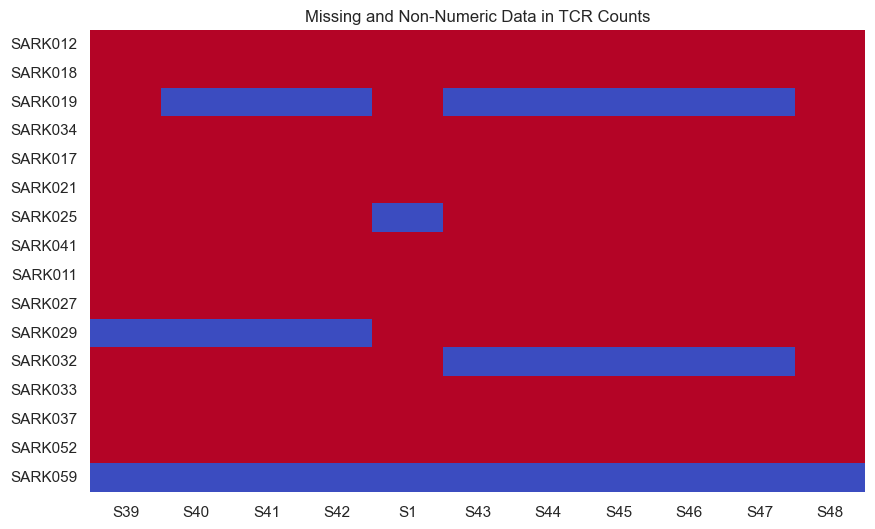

In [16]:
## 🚀 **1. Heatmap for Missing Data**
plt.figure(figsize=(10, 6))
sns.heatmap(df_cluster.isna(), cmap="coolwarm", cbar=False)
plt.title("Missing and Non-Numeric Data in TCR Counts")
plt.show()


### Distribution of counts

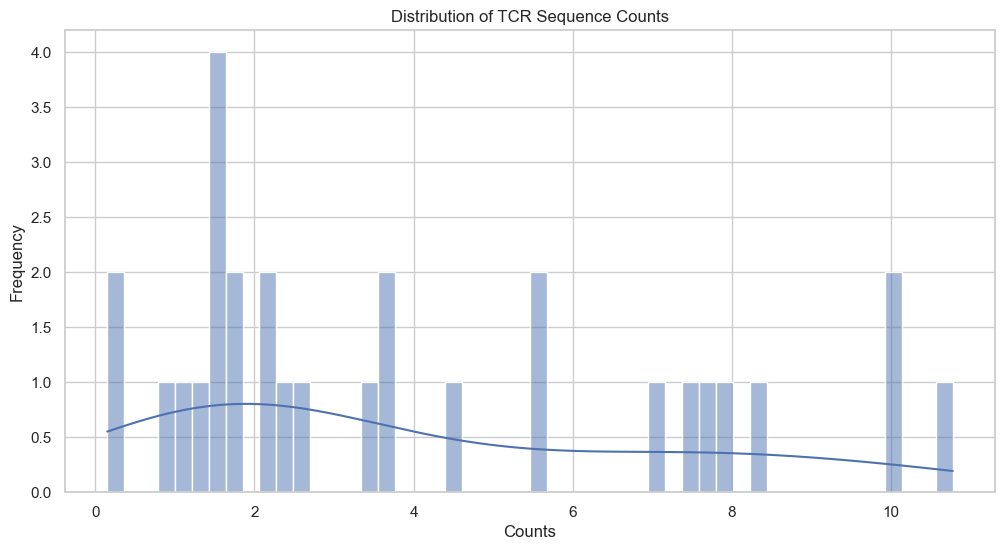

In [17]:
## 🚀 **2. Distribution of TCR Counts**
plt.figure(figsize=(12, 6))
sns.histplot(df_cluster.melt(value_name="counts")["counts"], bins=50, kde=True)
plt.title("Distribution of TCR Sequence Counts")
plt.xlabel("Counts")
plt.ylabel("Frequency")
plt.show()

### Boxplots

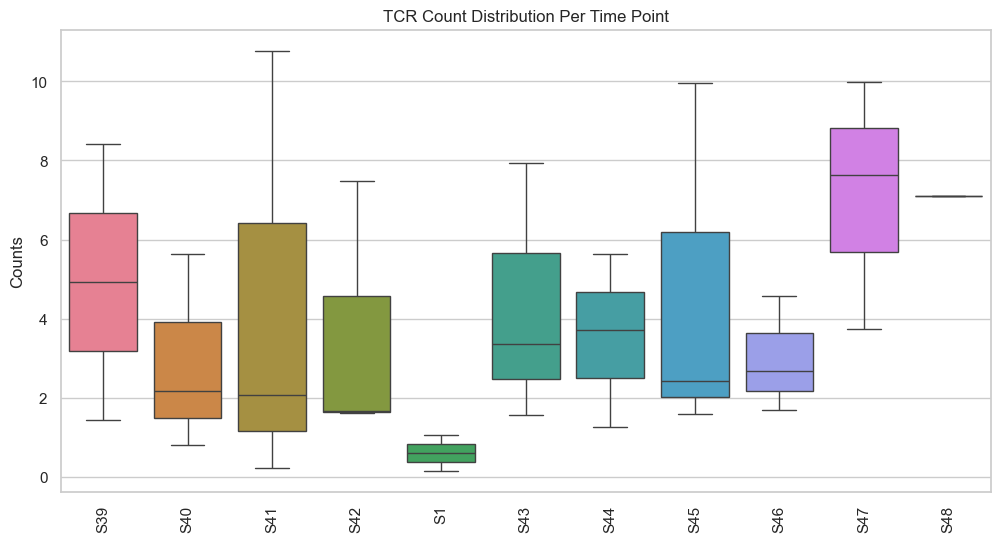

In [18]:
## 🚀 **3. Box Plot for Outlier Detection**
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cluster)
plt.xticks(rotation=90)
plt.title("TCR Count Distribution Per Time Point")
plt.ylabel("Counts")
plt.show()

### Lineplots

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


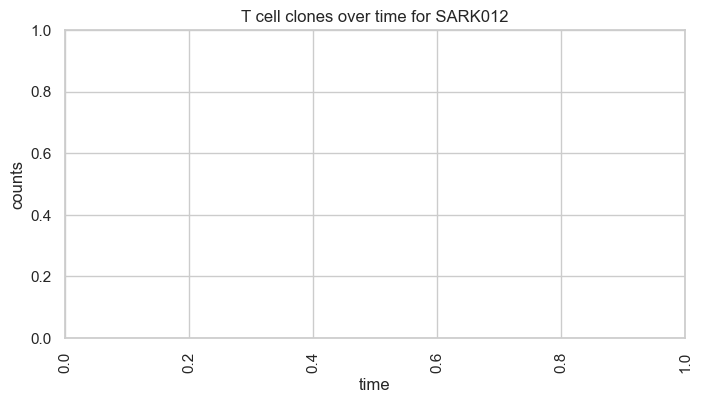

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


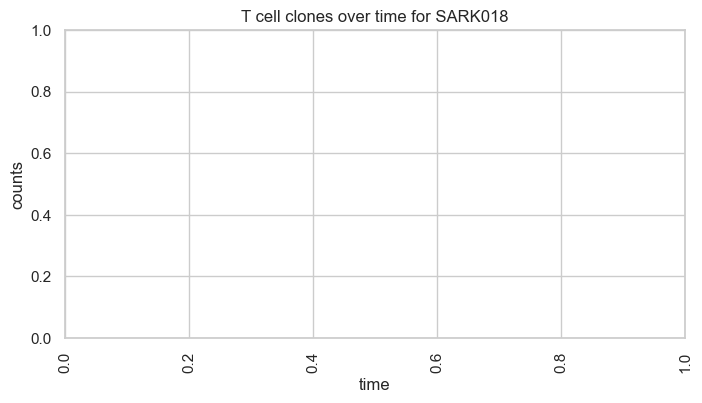

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


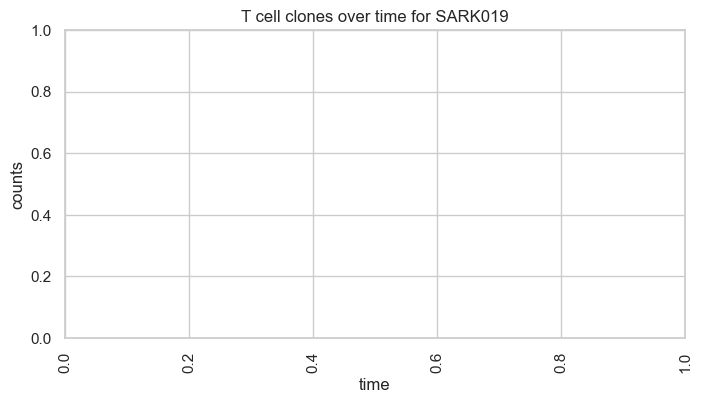

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


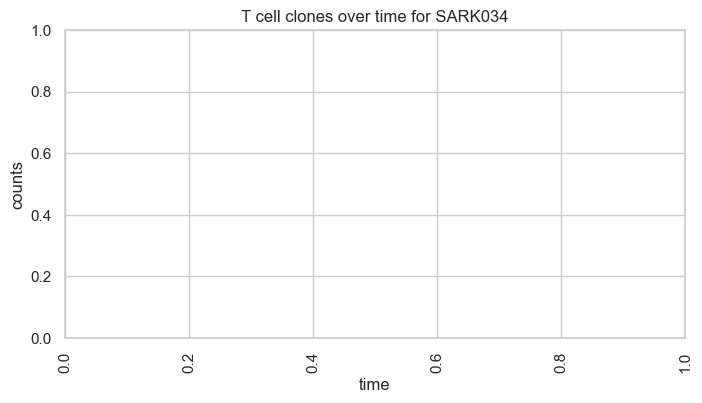

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


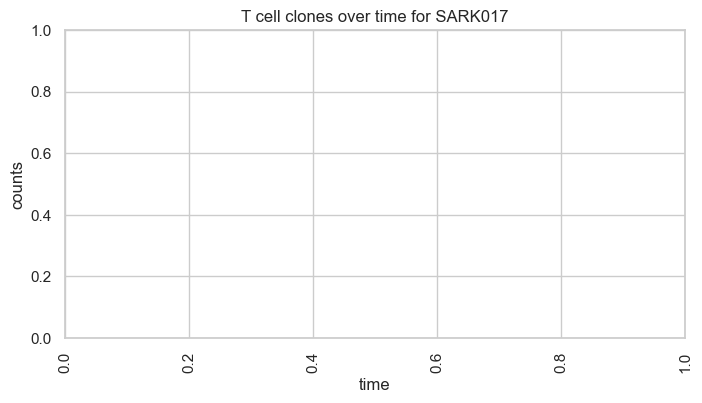

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


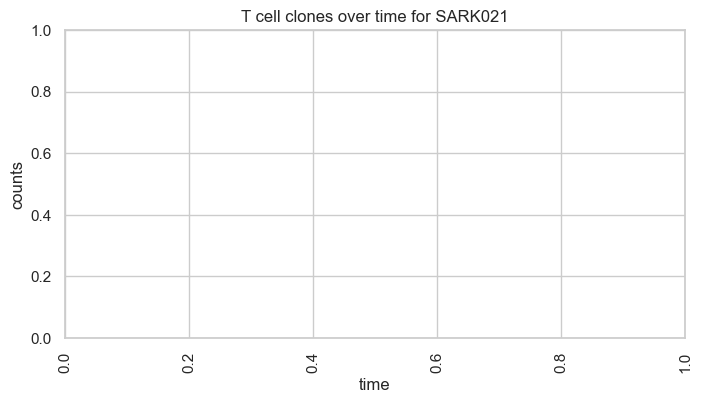

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


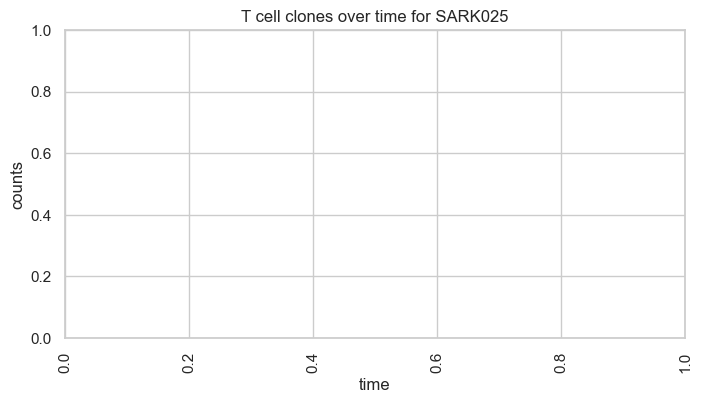

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


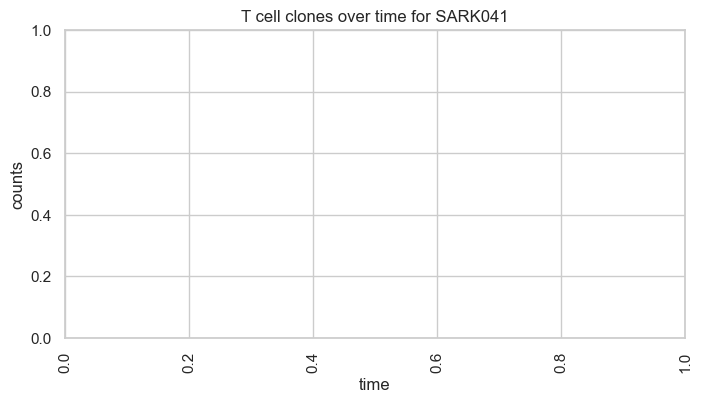

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


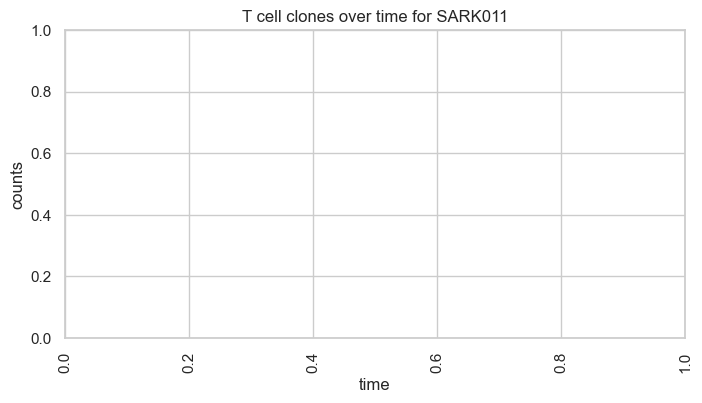

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


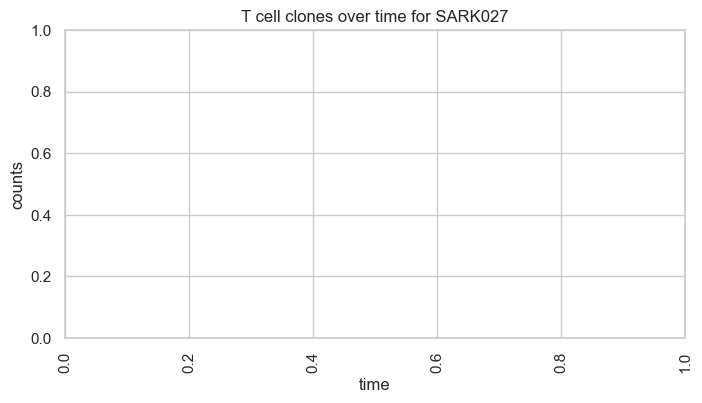

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


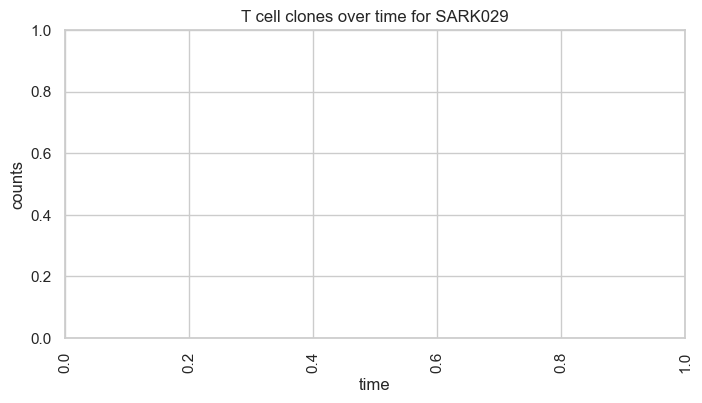

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


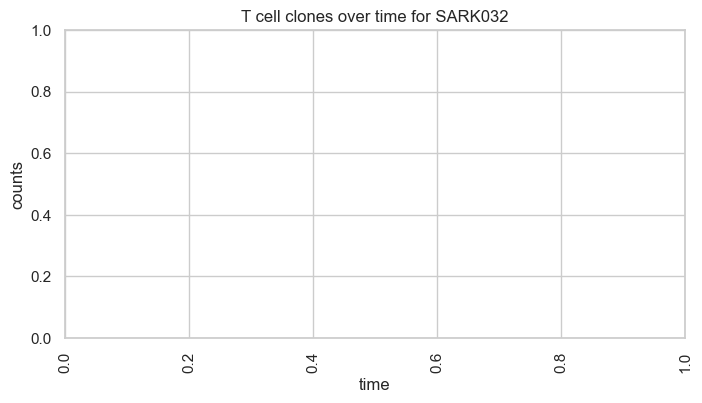

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


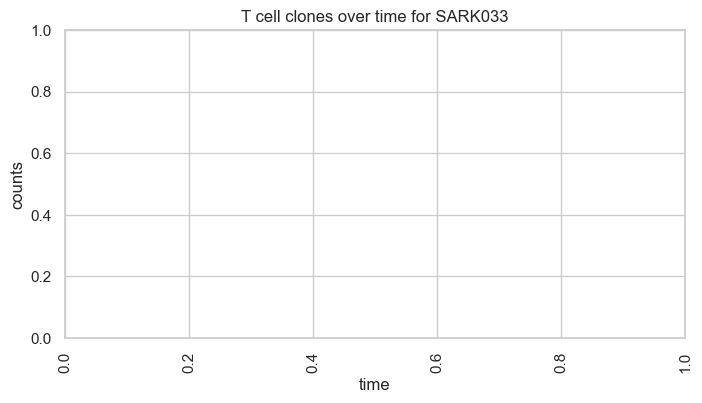

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


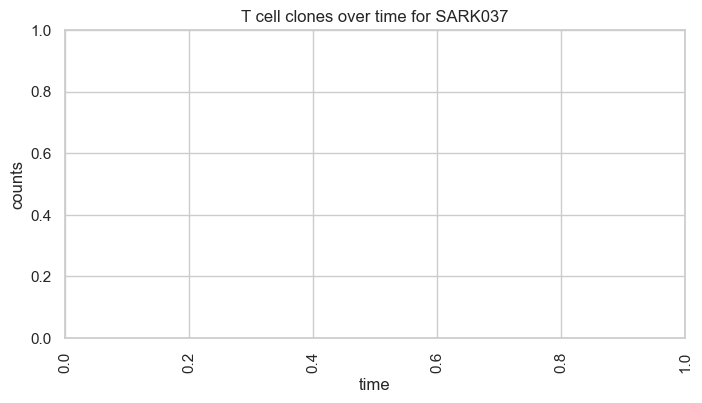

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


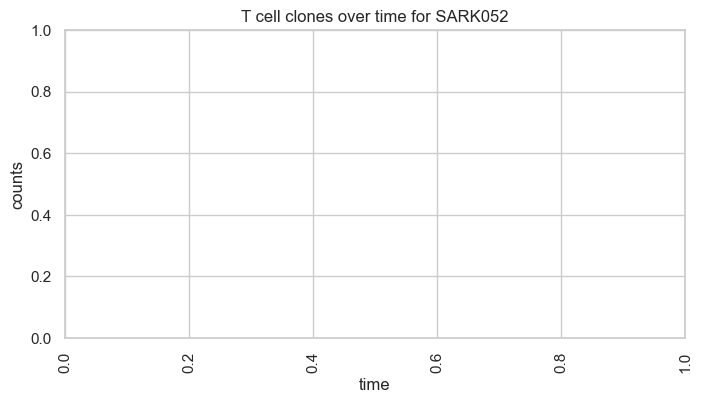

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


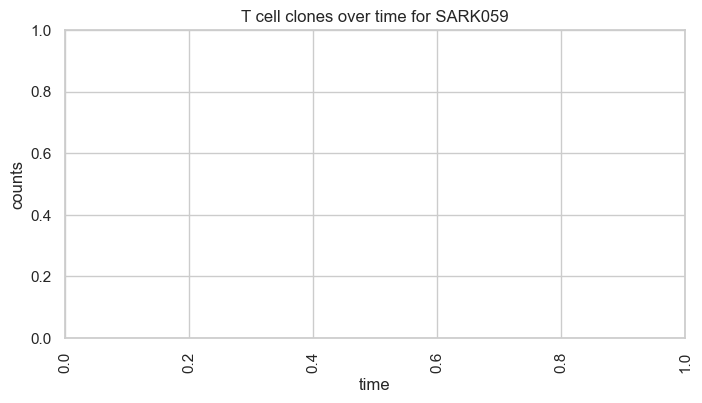

In [19]:
## 🚀 **4. Line Plot for TCR Dynamics Over Time**
for pat in pat_list:
    tcr_counts_m_patient = tcr_counts_m[tcr_counts_m['id'].str.contains(pat)]
    
    if len(tcr_counts_m_patient) > 5000:  # Avoid plotting thousands of lines
        sampled_ids = np.random.choice(tcr_counts_m_patient['id'].unique(), 100, replace=False)
        tcr_counts_m_patient = tcr_counts_m_patient[tcr_counts_m_patient['id'].isin(sampled_ids)]
    
    plt.figure(figsize=(8, 4))
    sns.lineplot(data=tcr_counts_m_patient, x='time', y='counts', hue='id', style='id', markers=True, dashes=False, alpha=0.5)
    plt.xticks(rotation=90)
    plt.title(f'T cell clones over time for {pat}')
    plt.legend().remove()
    plt.show()


### Heatmaps

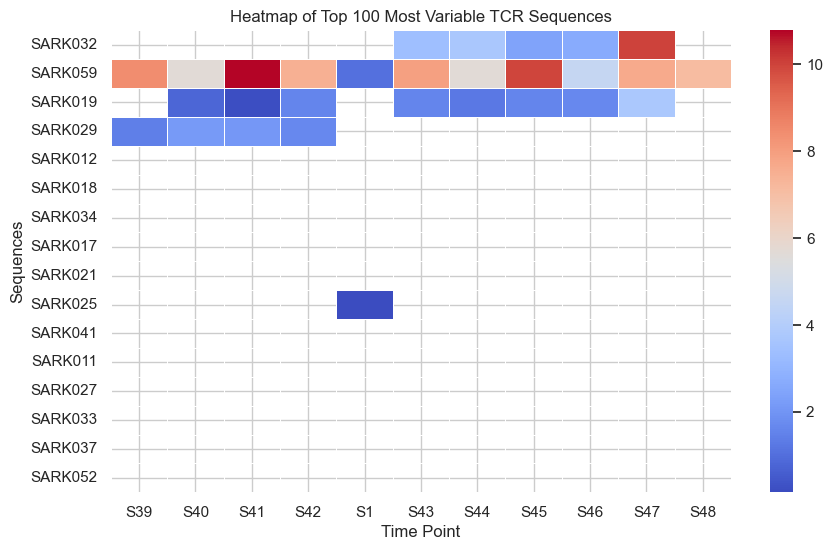

In [20]:
## 🚀 **5. Heatmap of Top 100 Most Variable Sequences**
df_var = df_cluster.var(axis=1)
top_100 = df_var.nlargest(100).index
df_top100 = df_cluster.loc[top_100]

plt.figure(figsize=(10, 6))
sns.heatmap(df_top100, cmap="coolwarm", linewidths=0.5)
plt.title("Heatmap of Top 100 Most Variable TCR Sequences")
plt.xlabel("Time Point")
plt.ylabel("Sequences")
plt.show()

### PCA for clustering

In [21]:
## 🚀 **6. PCA for Clustering**
X = df_cluster.values
X = np.log1p(X)  # Apply log transformation to reduce variability
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find optimal K with Silhouette Score
sil_scores = []
k_range = range(2, 10)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

optimal_k = k_range[np.argmax(sil_scores)]
print(f"Optimal Number of Clusters: {optimal_k}")

# Apply K-Means
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
clusters = kmeans.fit_predict(X_scaled)

# Reduce to 2D
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=["PC1", "PC2"], index=df_cluster.index)
pca_df["Sarcoma Type"] = df_cluster.index
pca_df["Cluster"] = clusters

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x="PC1", y="PC2", hue="Sarcoma Type", style="Cluster", palette="tab10", s=100)
plt.title("PCA + K-Means Clustering of TCR Expression")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()

ValueError: Input X contains NaN.
KMeans does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

### Hyerarchical CLustering

In [22]:
## 🚀 **7. Hierarchical Clustering**
plt.figure(figsize=(12, 6))
linked = linkage(X_scaled, method="ward")
dendrogram(linked, labels=df_cluster.index, leaf_rotation=45, leaf_font_size=10, color_threshold=5)
plt.title("Hierarchical Clustering of Sarcoma Types")
plt.xlabel("Sarcoma Type")
plt.ylabel("Distance")
plt.grid(True)
plt.show()

ValueError: The condensed distance matrix must contain only finite values.

<Figure size 1200x600 with 0 Axes>

### Violin Plot for Distribution Shape

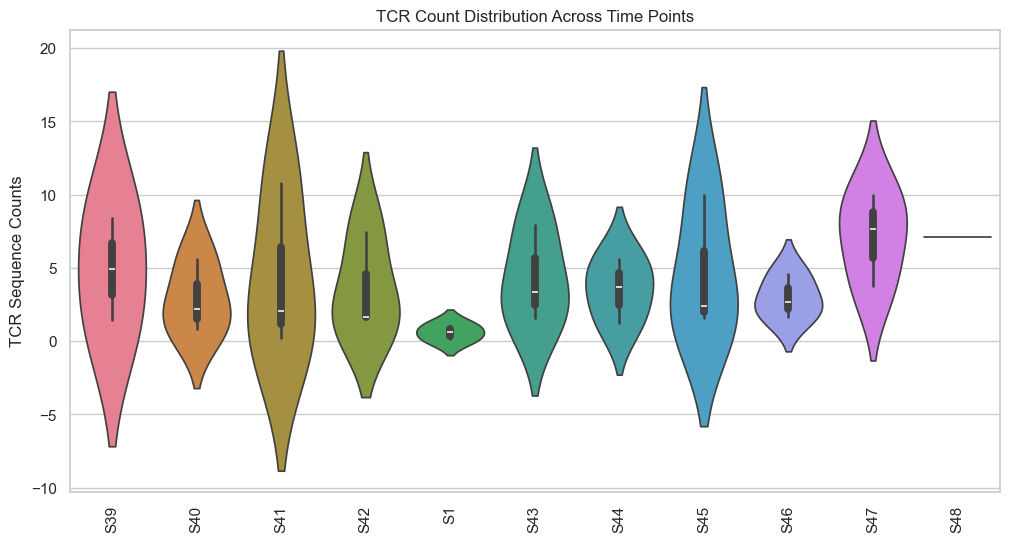

In [23]:
## 🚀 **8. Violin Plot for Distribution Shape**
plt.figure(figsize=(12, 6))
sns.violinplot(data=df_cluster)
plt.xticks(rotation=90)
plt.title("TCR Count Distribution Across Time Points")
plt.ylabel("TCR Sequence Counts")
plt.show()